In [46]:
np.__version__




'1.23.3'

In [3]:
import bilby
import numpy as np 
import time
import sys
import matplotlib.pyplot as plt
from multiprocessing import Pool
import multiprocessing
from functools import partial
from matplotlib.pyplot import MultipleLocator
from bilby.gw import conversion
from scipy.optimize import leastsq
import json
from pycbc.filter import matched_filter,matched_filter_core
from pycbc.types.timeseries import TimeSeries
from pycbc.types.frequencyseries import FrequencySeries
from lal import LIGOTimeGPS

import sealgw
from sealgw import seal
import sealgw.calculation as sealcal
import sealgw.simulation as sealsim

In [45]:
import spiir.io
xml_filepath = 'example_inputs/H1L1V1_1187008882_3_806.xml'
xmlfile = spiir.io.ligolw.coinc.load_coinc_xml(xml_filepath)

trigger_time, ndet, ntimes_array, det_names, max_snr_array, sigma_array_readfromxml, time_arrays, snr_arrays =\
        sealcal.localization.extract_info_from_xml(xml_filepath, return_names=True)

xml processing done. 
Trigger time: 1187008882.4453125
Detectors: ['H1', 'L1', 'V1']
SNRs: [15.10651112 24.52303505  1.96168923]
sigmas: [1969.1236365  1677.65263077  912.23831788]


In [54]:
# from 170817 xml
injection_parameters = dict(mass_1 = 2.783163/2, mass_2 = 2.783163/2, chi_1=0.023, chi_2=0.027, lambda_1=425, lambda_2=425,
                            luminosity_distance=40., theta_jn=157/57.3, psi=2.6, phase=1.3, geocent_time=1126259642.4, ra=3.446, dec=-0.408)

injection_parameters_sigma = injection_parameters.copy()
injection_parameters_sigma['theta_jn'] = 0
injection_parameters_sigma['luminosity_distance'] = 1
hc_fd = waveform_generator.frequency_domain_strain(injection_parameters_sigma)['plus']

duration = 320. # 16
sampling_frequency = 4096


waveform_arguments = dict(waveform_approximant='TaylorF2', minimum_frequency=20.)

waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_neutron_star,
    waveform_arguments=waveform_arguments)

det_names = ['H1', 'L1', 'V1']

ifos_chichiPSD = bilby.gw.detector.InterferometerList(det_names)
ifos_xmlPSD = bilby.gw.detector.InterferometerList(det_names)
ifos_tempgenPSD = bilby.gw.detector.InterferometerList(det_names)

sigma_chichiPSD = []
sigma_xmlPSD = []
sigma_tempgenPSD = []

psd_files = ['example_inputs/H1_psd.txt','example_inputs/L1_psd.txt', 'example_inputs/V1_psd.txt']
for i in range(len(ifos_xmlPSD)):
    det_xml = ifos_xmlPSD[i]
    det_xml.duration = duration
    det_xml.sampling_frequency = sampling_frequency
    xmlpsd = xmlfile['psds'][det_names[i]]
    psd = bilby.gw.detector.PowerSpectralDensity(frequency_array=np.array(list(xmlpsd.index)), psd_array=xmlpsd.values)
    det_xml.power_spectral_density = psd 
    sigma = bilby.gw.utils.noise_weighted_inner_product(hc_fd, hc_fd, det_xml.power_spectral_density_array, det_xml.duration)
    sigma = np.sqrt( np.real(sigma) )
    sigma_xmlPSD.append(sigma)
    
    det_chichi = ifos_chichiPSD[i]
    det_chichi.duration = duration
    det_chichi.sampling_frequency = sampling_frequency
    psd = bilby.gw.detector.PowerSpectralDensity(psd_file=psd_files[i])
    det_chichi.power_spectral_density = psd 
    sigma = bilby.gw.utils.noise_weighted_inner_product(hc_fd, hc_fd, det_chichi.power_spectral_density_array, det_chichi.duration)
    sigma = np.sqrt( np.real(sigma) )
    sigma_chichiPSD.append(sigma)
    
    det_tempgen = ifos_tempgenPSD[i]
    det_tempgen.duration = duration
    det_tempgen.sampling_frequency = sampling_frequency
    psd = bilby.gw.detector.PowerSpectralDensity(psd_file=psd_files[i])
    det_tempgen.power_spectral_density = psd 
    sigma = bilby.gw.utils.noise_weighted_inner_product(hc_fd, hc_fd, det_tempgen.power_spectral_density_array, det_tempgen.duration)
    sigma = np.sqrt( np.real(sigma) )
    sigma_tempgenPSD.append(sigma)
    
print('Paper sigma: ', [142*8.0,213*8.0,60*8.0])
print('Chichi PSD sigma: ', sigma_chichiPSD)
print('Template generation PSD sigma: ', sigma_tempgenPSD)
print('XML PSD sigma: ', sigma_xmlPSD)
print('XML deff*snr sigma: ', sigma_array_readfromxml)



15:25 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


Paper sigma:  [1136.0, 1704.0, 480.0]
Chichi PSD sigma:  [1169.4275717395635, 1733.6420459957853, 488.5234479411478]
Template generation PSD sigma:  [1169.4275717395635, 1733.6420459957853, 488.5234479411478]
XML PSD sigma:  [2387.659175589586, 3398.941185795076, 832.6676660141364]
XML deff*snr sigma:  [1969.1236365  1677.65263077  912.23831788]


In [57]:
1169.42/8

146.1775

In [50]:
psd_tempgen = spiir.io.ligolw.load_psd_series_from_xml('/Users/qianhu/Downloads/gstlal_H1L1V1-REFERENCE_PSD-1186624818-687900.xml.gz')

In [ ]:
psd_tempgen[]

In [ ]:
psd_files2 = ['/Users/qianhu/Downloads/H1-GSTLAL_SPLIT_BANK_0003-0-0.xml.gz',
              '/Users/qianhu/Downloads/L1-GSTLAL_SPLIT_BANK_0003-0-0.xml.gz',
              '/Users/qianhu/Downloads/V1-GSTLAL_SPLIT_BANK_0003-0-0.xml.gz']




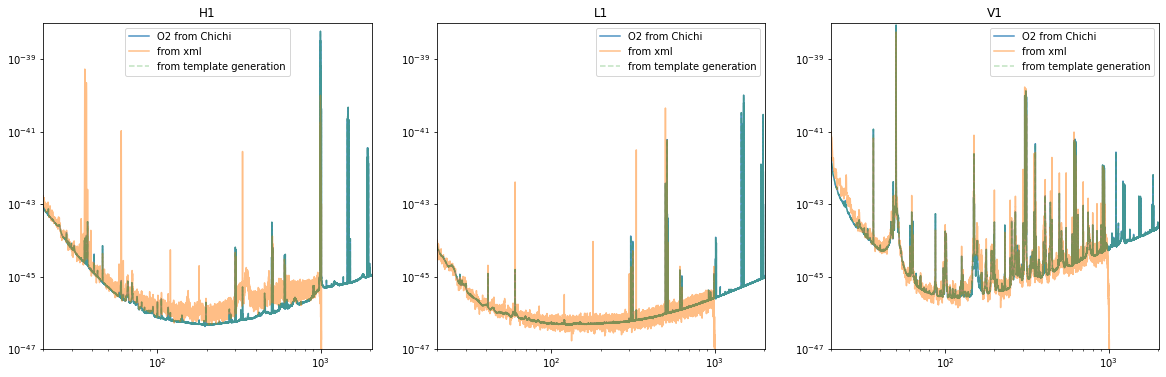

In [53]:
plt.figure(figsize=(20,6))
for i in range(len(ifos_chichiPSD)):
    psd_files = ['example_inputs/H1_psd.txt','example_inputs/L1_psd.txt', 'example_inputs/V1_psd.txt']
    psd_file = psd_files[i]
    psd_chichi = np.loadtxt(psd_file)
    plt.subplot(1,3,i+1)
    plt.loglog(psd_chichi[:,0], psd_chichi[:,1], label='O2 from Chichi', alpha=0.8)
    
    xmlpsd = xmlfile['psds'][det_names[i]]
    plt.loglog(np.array(list(xmlpsd.index)), xmlpsd.values, label="from xml", alpha=0.5)
    
    tempgenpsd = psd_tempgen[det_names[i]]
    plt.loglog(np.array(list(tempgenpsd.index)), tempgenpsd.values, label="from template generation", alpha=0.3, linestyle = '--')
    
    #plt.loglog(waveform_generator.frequency_array,abs(hc_fd)**2,label='hp')
    plt.title(det_names[i])
    plt.legend()
    plt.xlim(20,2048)
    plt.ylim(1e-47,1e-38)

In [23]:
ifos_chichiPSD.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency, duration=duration,
    start_time=injection_parameters['geocent_time'] - duration + 1)
ifos_chichiPSD.inject_signal(waveform_generator=waveform_generator,
                parameters=injection_parameters)


08:56 bilby INFO    : Injected signal in H1:
08:56 bilby INFO    :   optimal SNR = 24.74
08:56 bilby INFO    :   matched filter SNR = 24.18-0.44j
08:56 bilby INFO    :   mass_1 = 1.3915815
08:56 bilby INFO    :   mass_2 = 1.3915815
08:56 bilby INFO    :   chi_1 = 0.023
08:56 bilby INFO    :   chi_2 = 0.027
08:56 bilby INFO    :   lambda_1 = 425
08:56 bilby INFO    :   lambda_2 = 425
08:56 bilby INFO    :   luminosity_distance = 40.0
08:56 bilby INFO    :   theta_jn = 2.7399650959860384
08:56 bilby INFO    :   psi = 2.6
08:56 bilby INFO    :   phase = 1.3
08:56 bilby INFO    :   geocent_time = 1126259642.4
08:56 bilby INFO    :   ra = 3.446
08:56 bilby INFO    :   dec = -0.408
08:56 bilby INFO    : Injected signal in L1:
08:56 bilby INFO    :   optimal SNR = 34.77
08:56 bilby INFO    :   matched filter SNR = 35.63+0.00j
08:56 bilby INFO    :   mass_1 = 1.3915815
08:56 bilby INFO    :   mass_2 = 1.3915815
08:56 bilby INFO    :   chi_1 = 0.023
08:56 bilby INFO    :   chi_2 = 0.027
08:56 b

[{'plus': array([ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j, ...,
         -2.08787633e-25+2.00959217e-25j, -2.08797800e-25+2.00947908e-25j,
         -2.08807968e-25+2.00936599e-25j]),
  'cross': array([ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j, ...,
         -2.00270342e-25-2.08071922e-25j, -2.00259072e-25-2.08082055e-25j,
         -2.00247802e-25-2.08092188e-25j])},
 {'plus': array([ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j, ...,
         -2.08787633e-25+2.00959217e-25j, -2.08797800e-25+2.00947908e-25j,
         -2.08807968e-25+2.00936599e-25j]),
  'cross': array([ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j, ...,
         -2.00270342e-25-2.08071922e-25j, -2.00259072e-25-2.08082055e-25j,
         -2.00247802e-25-2.08092188e-25j])},


In [24]:

ifos_xmlPSD.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency, duration=duration,
    start_time=injection_parameters['geocent_time'] - duration + 1)
ifos_xmlPSD.inject_signal(waveform_generator=waveform_generator,
                parameters=injection_parameters)

08:56 bilby INFO    : Injected signal in H1:
08:56 bilby INFO    :   optimal SNR = 50.52
08:56 bilby INFO    :   matched filter SNR = 51.85-0.75j
08:56 bilby INFO    :   mass_1 = 1.3915815
08:56 bilby INFO    :   mass_2 = 1.3915815
08:56 bilby INFO    :   chi_1 = 0.023
08:56 bilby INFO    :   chi_2 = 0.027
08:56 bilby INFO    :   lambda_1 = 425
08:56 bilby INFO    :   lambda_2 = 425
08:56 bilby INFO    :   luminosity_distance = 40.0
08:56 bilby INFO    :   theta_jn = 2.7399650959860384
08:56 bilby INFO    :   psi = 2.6
08:56 bilby INFO    :   phase = 1.3
08:56 bilby INFO    :   geocent_time = 1126259642.4
08:56 bilby INFO    :   ra = 3.446
08:56 bilby INFO    :   dec = -0.408
08:56 bilby INFO    : Injected signal in L1:
08:56 bilby INFO    :   optimal SNR = 68.16
08:56 bilby INFO    :   matched filter SNR = 69.30-0.09j
08:56 bilby INFO    :   mass_1 = 1.3915815
08:56 bilby INFO    :   mass_2 = 1.3915815
08:56 bilby INFO    :   chi_1 = 0.023
08:56 bilby INFO    :   chi_2 = 0.027
08:56 b

[{'plus': array([ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j, ...,
         -2.08787633e-25+2.00959217e-25j, -2.08797800e-25+2.00947908e-25j,
         -2.08807968e-25+2.00936599e-25j]),
  'cross': array([ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j, ...,
         -2.00270342e-25-2.08071922e-25j, -2.00259072e-25-2.08082055e-25j,
         -2.00247802e-25-2.08092188e-25j])},
 {'plus': array([ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j, ...,
         -2.08787633e-25+2.00959217e-25j, -2.08797800e-25+2.00947908e-25j,
         -2.08807968e-25+2.00936599e-25j]),
  'cross': array([ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j, ...,
         -2.00270342e-25-2.08071922e-25j, -2.00259072e-25-2.08082055e-25j,
         -2.00247802e-25-2.08092188e-25j])},
